<a href="https://colab.research.google.com/github/SheryllD/diabetic_retinopathy_ml/blob/main/Diabetic_Retinopathy_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New section

## 1. Setup and Imports

In [205]:
# Install Kaggle API
!pip install Kaggle

In [206]:
!pip install opencv-python # For colour enhancement preprocessing

### Libraries

In [207]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
from PIL import Image

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')
print("Necessary modules have been imported")

Necessary modules have been imported


In [208]:
print(tf.__version__)

2.18.0


In [156]:
!which python

/usr/local/bin/python


## 2. Mount Drive and Set up Kaggle

In [209]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Keys/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized
License(s): unknown
^C


## 3. Loading Dataset

In [210]:
# Importing kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tanlikesmath/diabetic-retinopathy-resized")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/diabetic-retinopathy-resized


### Dataset Paths

In [211]:
# Reviewing the paths
print("Downloaded path:", path)
print("Contents of the folder:")
print(os.listdir(path))

Downloaded path: /kaggle/input/diabetic-retinopathy-resized
Contents of the folder:
['resized_train', 'trainLabels.csv', 'resized_train_cropped', 'trainLabels_cropped.csv']


In [212]:
base_path = "/root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7"
print("Contents:", os.listdir(base_path))

# base_path = "/kaggle/input/diabetic-retinopathy-resized"
# print("Contents:", os.listdir(base_path))

Contents: ['trainLabels_cropped.csv', 'resized_train', 'trainLabels.csv', 'resized_train_cropped']


### Load and Clean CSV

In [213]:
# I am using the cropped images to reduce the noise

df_images = os.path.join(base_path, "resized_train_cropped", "resized_train_cropped")
labels = os.path.join(base_path, "trainLabels_cropped.csv")

print("Images folder: ", df_images)
print("Labels file:", labels)

Images folder:  /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped
Labels file: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/trainLabels_cropped.csv


In [214]:
# Loading the CSV
df_labels = pd.read_csv(labels, header=0)
print(df_labels.head())

   Unnamed: 0.1  Unnamed: 0     image  level
0             0           0   10_left      0
1             1           1  10_right      0
2             2           2   13_left      0
3             3           3  13_right      0
4             4           4   15_left      1


## 4. EDA (Exploratory Data Analysis) & Binary Labeling

In [215]:
#Number values
images_files = os.listdir(df_images)

print(f"Number of images:", {len(images_files)})
print(f"Number of inputs (labels):", {len(df_labels)})

Number of images: {35108}
Number of inputs (labels): {35108}


In [216]:
# Reviewing the basic info
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35108 entries, 0 to 35107
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  35108 non-null  int64 
 1   Unnamed: 0    35108 non-null  int64 
 2   image         35108 non-null  object
 3   level         35108 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [217]:
# Droppng the unnamed:0 columns to minimise noise
df_labels = df_labels.drop(columns=["Unnamed: 0.1", "Unnamed: 0"])
print(df_labels.head(1))

     image  level
0  10_left      0


In [218]:
df_labels.describe()

level
count  35108.000000
mean       0.525863
std        0.970372
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.000000

In [219]:
# How many missing?
df_labels.isna().sum()

image    0
level    0
dtype: int64

In [220]:
# How many duplicated?
df_labels.duplicated().sum()

np.int64(0)

## 5. Class Distribution

In [221]:
df_num_columns = df_labels.select_dtypes(include="number")
df_num_columns

level
0          0
1          0
2          0
3          0
4          1
...      ...
35103      0
35104      0
35105      0
35106      0
35107      1

[35108 rows x 1 columns]

In [222]:
# How many classes?
print("Unique labels", df_labels['level'].unique())
print("Class distribution:\n", df_labels["level"].value_counts())
print("Total:", df_labels.value_counts())

Unique labels [0 1 2 4 3]
Class distribution:
 level
0    25802
2     5288
1     2438
3      872
4      708
Name: count, dtype: int64
Total: image        level
99_right     3        1
10003_left   0        1
10003_right  0        1
10007_left   0        1
9980_right   0        1
                     ..
10010_left   0        1
1000_right   0        1
1000_left    0        1
10009_right  0        1
10009_left   0        1
Name: count, Length: 35108, dtype: int64


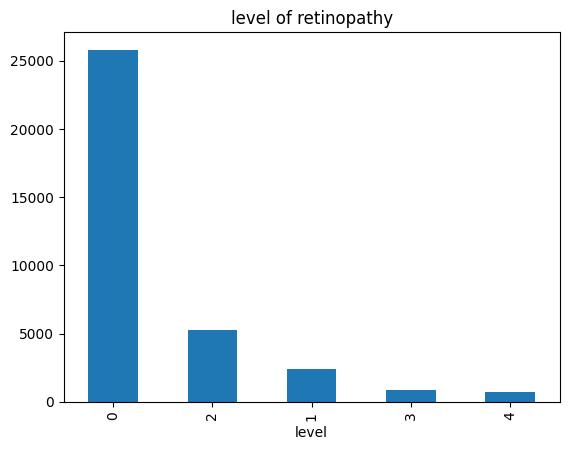

In [223]:
df_labels["level"].value_counts().plot(kind="bar")
plt.title("level of retinopathy")
plt.ylabel("")
plt.show()

0 → no DR
1 → mild
2 → moderate
3 → severe
4 → proliferative

I can see that the data is very imbalanced.

The data is very inbalanced. So the decision is to group 1, 2, 3, 4, together as 0: 'N0 DR',  1: 'Yes DR'.

Solution:
- Random under-sampling is useful but blunt.
- Using moderate under-sampling + augmentation + class_weight is the gold standard.

This ensures you don’t accidentally lose critical healthy examples.

In [224]:
print(df_labels.columns)

Index(['image', 'level'], dtype='object')


### Reviewing the **images**

In [225]:
# df_images = pd.read_csv(df_images)
# print(df_labels.head())

# Confirming folder variable
print("Images folder path:", df_images)
print("Example files inside:", os.listdir(df_images)[:5])

Images folder path: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped
Example files inside: ['36286_left.jpeg', '31889_right.jpeg', '24328_left.jpeg', '17042_right.jpeg', '10042_left.jpeg']


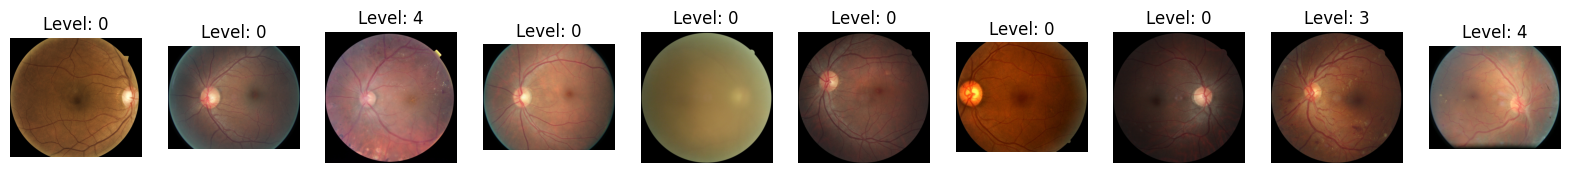

In [226]:
# picking random images
sample = df_labels.sample(10, random_state=42)

# plotting 10 random samples side by side for better overview
fig, axes = plt.subplots(1, 10, figsize=(20, 5))

for ax, (_, row) in zip(axes, sample.iterrows()):
    img_path = os.path.join(df_images, row['image'] + '.jpeg')
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Level: {row['level']}")
    ax.axis('off')
plt.show()

# for idx, row in sample.iterrows():
#   img_path = os.path.join(df_images, row['image'] + '.jpeg')
#   img = Image.open(img_path)
#   plt.imshow(img)
#   plt.title(f"Label: {row['level']}")
#   plt.axis("off")
#   plt.show()

In [227]:
# # resizing the images

# image_size = 224
# batch_size = 32
# num_classes = df_labels['level'].unique()

# print(f"Image size: {image_size}x{image_size}")
# print(f"Number of classes: {num_classes}")

In [239]:
# Removing dark areas around the image while preserving the important center
IMG_SIZE = 224

def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        if mask.any():
            img1 = img[np.ix_(mask.any(1), mask.any(0))]
            return img1
    return img

def load_ben_color(path, sigmaX=30):
    image = cv2.imread(path)
    if image is None:
        raise ValueError(f"Could not read image from path: {path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    return image / 255.0  # Normalised


In [229]:
img_path = df_train['path'].iloc[0]
print("Trying to load image at:", img_path)


Trying to load image at: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped/14950_right.jpeg


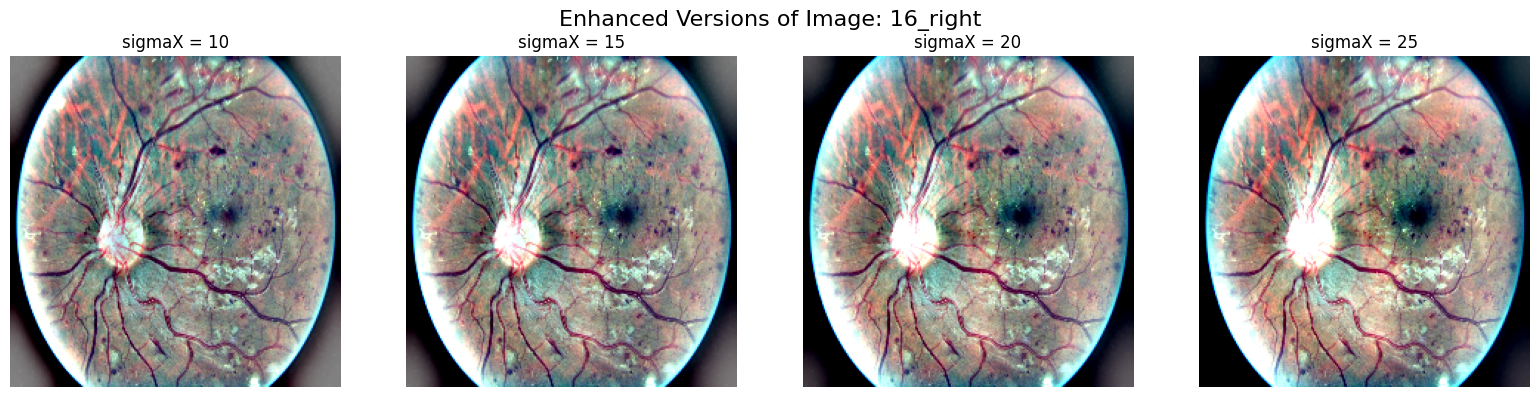

In [243]:
# Filter positive cases (level > 0)
df_positive = df_labels[df_labels['level'] > 0].reset_index(drop=True)

# Pick one example
img_id = df_positive['image'].iloc[3]
img_path = os.path.join(df_images, img_id + '.jpeg')

# Define sigmaX values to compare
sigma_values = [10, 15, 20, 25]

# Plotting
plt.figure(figsize=(16, 4))

for i, sigma in enumerate(sigma_values):
    # Apply enhancement
    img = load_ben_color(img_path, sigmaX=sigma)

    # Plot
    plt.subplot(1, len(sigma_values), i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'sigmaX = {sigma}')

plt.suptitle(f'Enhanced Versions of Image: {img_id}', fontsize=16)
plt.tight_layout()
plt.show()

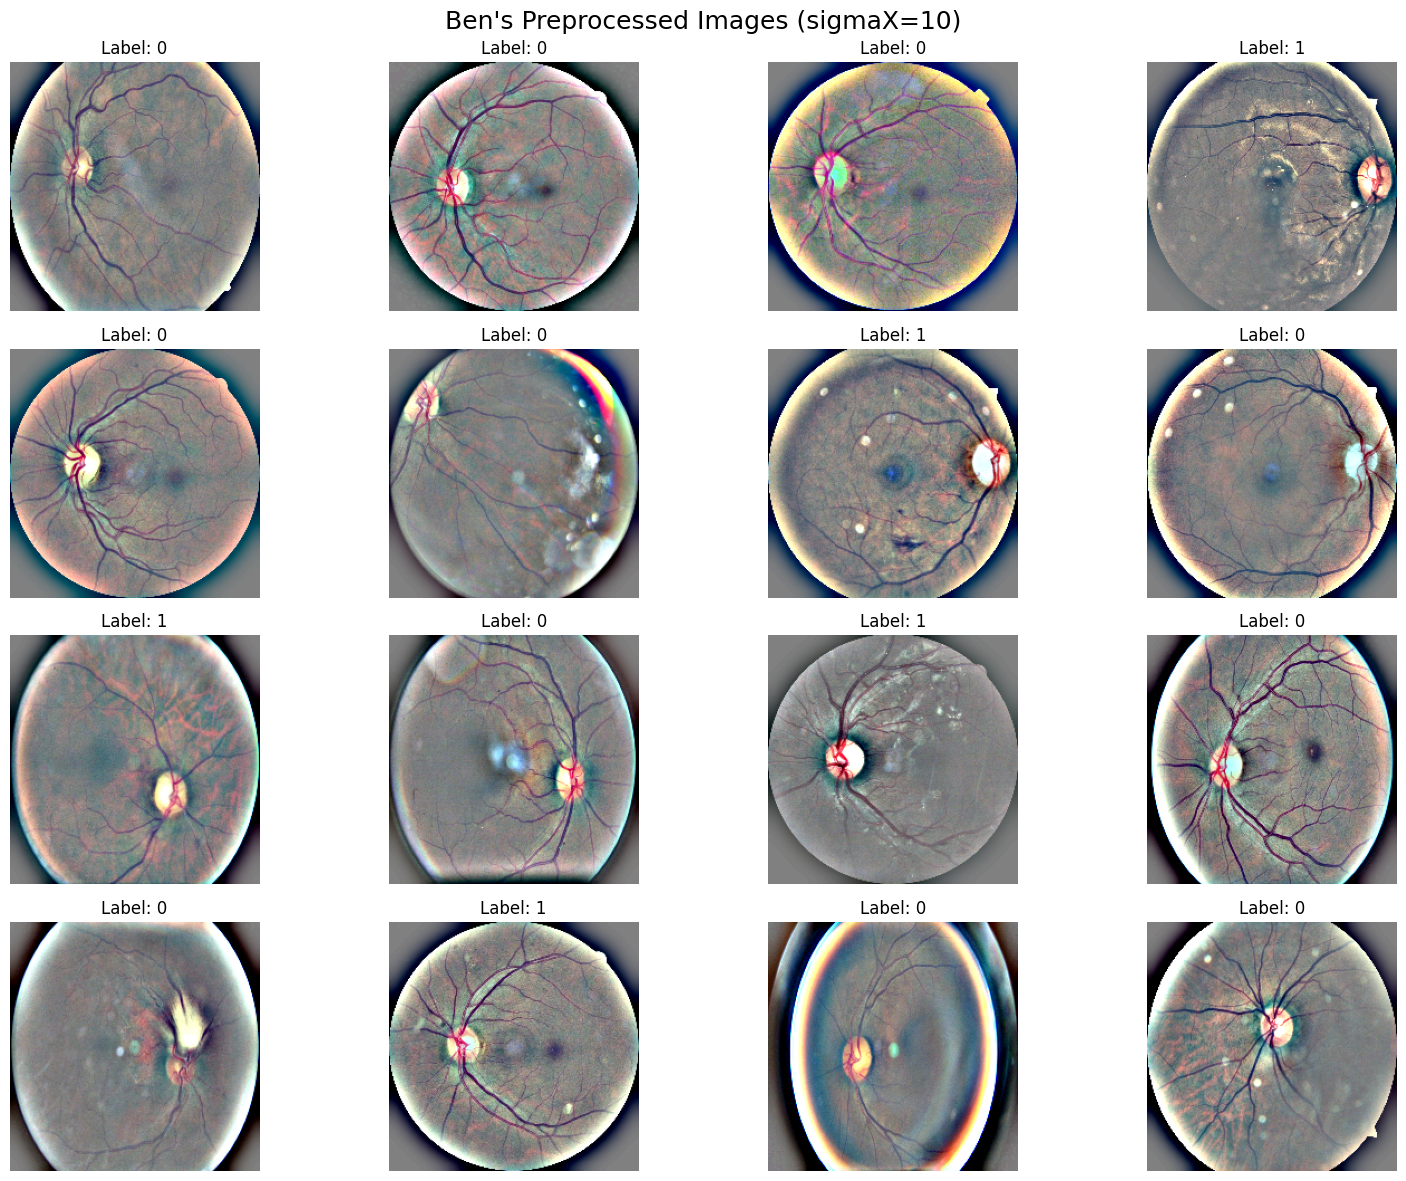

In [245]:
# import matplotlib.pyplot as plt

# # Pick a random sample of 8 images from the training set
# sample_df = df_train.sample(10, random_state=42)

# # Plotting
# plt.figure(figsize=(20, 5))

# for i, row in enumerate(sample_df.itertuples()):
#     try:
#         image = load_ben_color(row.path, sigmaX=10)
#         plt.subplot(2, 4, i + 1)
#         plt.imshow(image)
#         plt.axis('off')
#         plt.title(f"Label: {row.binary_level}")
#     except Exception as e:
#         print(f"Error loading image {row.path}: {e}")

# plt.suptitle("Ben's Enhanced Color Images", fontsize=16)
# plt.tight_layout()
# plt.show()


# Set the number of images
num_images = 16
rows, cols = 4, 4

# Sample from training data
sample_df = df_train.sample(num_images, random_state=42)

# Plotting
plt.figure(figsize=(16, 12))

for i, row in enumerate(sample_df.itertuples()):
    try:
        image = load_ben_color(row.path, sigmaX=10)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Label: {row.binary_level}")
    except Exception as e:
        print(f"Error loading image {row.path}: {e}")

plt.suptitle("Ben's Preprocessed Images (sigmaX=10)", fontsize=18)
plt.tight_layout()
plt.show()


## 6. Path Construction

In [248]:
# Adding image path to the label Dataframe, this is the full path
df_labels["path"] = df_labels["image"].apply(lambda x: os.path.join(df_images, x + ".jpeg"))

# I am only keeping the rows if they actually exist in the folder
df_labels = df_labels[df_labels['path'].apply(os.path.exists)].copy()

# Reviewing
print("Rows with valid filles:", len(df_labels))

Rows with valid filles: 35108


Now that we got 35108 back, we can see that we haven't lost any images or values.

## 7. Binary Classification

In [249]:
# Adding Binary column by grouping 1, 2, 3, 4 together as 1 'Has DR', 0 as 'No DR'.
df_labels['binary_level'] = df_labels['level'].apply(lambda x: 0 if x ==0 else 1)
print(df_labels[['level', 'binary_level']].head())

   level  binary_level
0      0             0
1      0             0
2      0             0
3      0             0
4      1             1


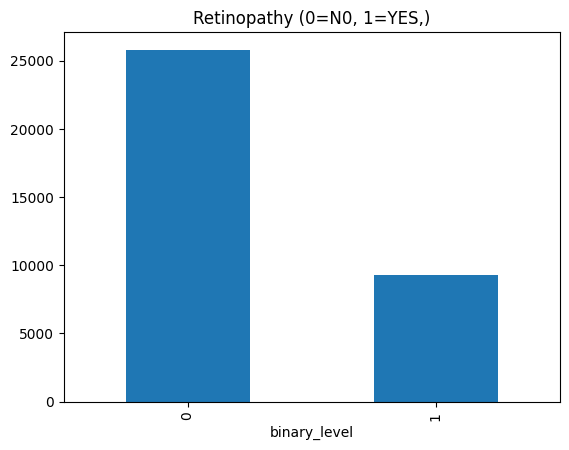

In [111]:
# Plotting
df_labels["binary_level"].value_counts().plot(kind="bar")
plt.title("Retinopathy (0=N0, 1=YES,)")
plt.ylabel("")
plt.show()

In [112]:
print(df_labels.head(10))
# print(df_labels.columns)

      image  level                                               path  \
0   10_left      0  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
1  10_right      0  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
2   13_left      0  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
3  13_right      0  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
4   15_left      1  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
5  15_right      2  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
6   16_left      4  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
7  16_right      4  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
8   17_left      0  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
9  17_right      1  /root/.cache/kagglehub/datasets/tanlikesmath/d...   

   binary_level  
0             0  
1             0  
2             0  
3             0  
4             1  
5             1  
6             1  
7             1  
8             0  
9             1 

## 8. Balance Dataset & Moderate Undersampling

### Moderate Undersampling
I am going to moderately undersample the data.

In [113]:
# Keep 2:1 (Moderate)
df_healthy = df_labels[df_labels['binary_level'] == 0]
df_dr = df_labels[df_labels['binary_level'] == 1]

desired_healthy = 2 * len(df_dr)
df_healthy_under = df_healthy.sample(desired_healthy, random_state=42)

balanced_labels = pd.concat([df_healthy_under, df_dr]).sample(frac=1, random_state=42).reset_index(drop=True)

balanced_labels['binary_level'].value_counts()

binary_level
0    18612
1     9306
Name: count, dtype: int64

I used moderate undersampling to keep the healthy class at twice the size of the DR-positive class, preserving useful healthy variation while reducing imbalance.

In [114]:
# Reviewing Tensorflow version
print(tf.__version__)

2.18.0


## 9. Class Weights

In [115]:
# Calculate the class_weight

classes = np.unique(balanced_labels['binary_level'])
weights = compute_class_weight(
    class_weight = 'balanced',
    classes = classes,
    y=balanced_labels['binary_level']
)
class_weight = dict(zip(classes, weights))
print(class_weight)

{np.int64(0): np.float64(0.75), np.int64(1): np.float64(1.5)}


np.int64(0): np.float64(0.75) --> healthy, gets weight 0.75
np.int64(1): np.float64(1.5) --> gets weight 1.5

- So if the model classifies a DR image --> the loss is multipliied by 1.5, which makes it more costly.
- If it misclassifies a healthy image --> loss is multiplied by 0.75, which is less costly.
In termsL It tells the model to pay extra attention to correctly detecting the DR.

For further developing during the training, pass:
- class_weight = {0: 0.75, 1: 1.5}


## 10. Train/Validation Split

In [116]:
# Splitting it into 80% training and 20% validation (stratify to keep label balance)
df_train, df_val = train_test_split(balanced_labels, test_size=0.2, stratify = balanced_labels['binary_level'], random_state=42)

# Checking train dataframe
print("Train:")
print(df_train['binary_level'].value_counts())

# Checking for valudation
print("\nValidation:")
print(df_val['binary_level'].value_counts())

Train:
binary_level
0    14889
1     7445
Name: count, dtype: int64

Validation:
binary_level
0    3723
1    1861
Name: count, dtype: int64


In [130]:
df_train['binary_level'] = df_train['binary_level'].astype(str)
df_val['binary_level'] = df_val['binary_level'].astype(str)

## 11. ImageDataGenerators
Image generators for comparison and use.

#### Defining the generators

In [131]:
# Training with augementation

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    zoom_range = 0.2,
    brightness_range = [0.7, 1.3],
    horizontal_flip =True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [132]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = "",
    x_col ='path',
    y_col ='binary_level',
    target_size = (224, 224),
    batch_size = 32,
    class_mode ='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = df_val,
    directory = None,
    x_col = 'path',
    y_col = 'binary_level',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = False
)

Found 22334 validated image filenames belonging to 2 classes.
Found 5584 validated image filenames belonging to 2 classes.


What I did so far:

1. Cleaned and prepared the dataset
- dropped extra columns
- verified I have 35108 valid image-label pairs
- created a binary label: 0 = No DR, 1 = Has DR

2. Used modeerate undersampling:
- reduced the healthy class to twice the size of DR (2:1)
- final count = healthy: 18.612,  DR: 9.306, Total: 27.918

3. Calculated class weights:
- {0: 0.75, 1: 1.5}
- Model willpenalises DR mistakes more than healthy mistakes.

4. Split into train/validation with stratify
- 80% train: Healthy: 14,889, DR: 7,445
- 20% validation: Healthy: 3,723, DR: 1,861

5. Converted labels to strings
- requrement by ImageDataGenerator

6. Defined Generators:
- train: uses augementations + rescaling
- validation: only rescaling
- Finding exat right number of images

Found 22334 validated image filenames belonging to 2 classes for Train.

Found 5584 validated image filenames belonging to 2 classes for validation.

This matches the split.
- 14,889 + 7,445 = 22,334 (train)
- 3,723 + 1,861 = 5,584 (validation)


Next step: Build and train the model
1. EfficientNetB0 block + compile + train (with class_weight)?
2. Also the custom CNN version side-by-side?
3. Or only EfficientNet for now, one clean block?

## 12. Tf.data Pipeline

In [133]:
# Turning the splits into tf.data.Dataset

# Parsing function
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image = image / 255.0
  return image, label

batch_size = 32

### Train dataset

In [134]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train['path'].values, df_train['binary_level'].values))
train_ds = train_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)

### Validation dataset

In [135]:
val_ds = tf.data.Dataset.from_tensor_slices((df_val['path'].values, df_val['binary_level'].values))
val_ds = val_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [136]:
# Inspecting 1 batch

for images, labels in train_ds.take(1):
  print(f"Images shape:", images.shape)
  print(f"Labels shape:", df_labels.shape)

Images shape: (32, 224, 224, 3)
Labels shape: (35108, 4)


### Computing class_weight

In [139]:
# Get unique classes
classes = np.unique(df_labels['binary_level'])
print("Classes:", classes)

# computing weights
weights = compute_class_weight(
    class_weight = 'balanced',
    classes = classes,
    y = df_train['binary_level'].astype(int) # Changing it back to int because for class weight you need to have it in int.
)

# Making dictionary for Keras
class_weight = dict(zip(classes, weights))
print("Classweights:", class_weight)

# safe casting to plain int and float types
class_weight = {int(k): float(v) for k, v, in class_weight.items()}

Classes: [0 1]
Classweights: {np.int64(0): np.float64(0.7500167909194707), np.int64(1): np.float64(1.4999328408327737)}


### Building & Compiling the model

In [147]:
# Loading the basemodel
base_model = EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights='imagenet'
)
base_model.trainable = False

# Building the full model
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x) # for Binary output

model = models.Model(inputs, outputs)

# Compiling the model in the optimizer and loss function

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'] # e.g metrics['binary_accuracy']
)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Notes:
- Adam is an SGD (Stochastic Gradient Descent) algorithm that has an adaptive learning rate that makes it suitable for most problems without any parameter tuning (it is 'self tuning', in a sense). Adam is a great general-purpose optimizer.

- After I have defined the model, I added also a loss function, in this case 'binary_crossentropy', and Adam as optimizer.

- Gradient is a vector that tells us in what direction the weights need to go. And more precisely, it tells us how to change the weights to make the loss change fastest. The reason why we call it process gradient descent, because it uses gradient to descend the loss curve towards a minimum, Stochastics means 'determinede by chance', the training is stochastic because the batches are random samples from the dataset, thus why it's called SGD.

- Crosse-entropy function:
The problem with accuracy (and most other classification metircs) is that it can't bee used as a loss function. SGD needs a loss function that changes smoothly, but accuracy, being a ratio of counts, changes in "jumps". So, we have to choose a substitute to act as the loss function. So in this case it is the cross-entropy function.
- So for classification, what we want instead is a distance between probabilities, and this is what cross-entropy provides. Cross-entropy is a sort of measure for the distance from one probabillity distribution to another.
- Ideally we want the netework to predict the correct class with a probability 1.0. The furuther away the predicted probability is from 1.0, the greater the cross-entropy loss.

In [151]:
# Turning the splits into tf.data.Dataset and updating the parse_image

# Parsing function
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image = image / 255.0
  label = label = tf.cast(label, tf.float32)
  return image, label

batch_size = 32

Notes: Smaller batch sizes give noisier weight updates and loss curves. The reason is because each batch is a small sample of data abd smaller samples tend to give noicier estimates. So smaller batches can have an averaging effect though which can be beneficial.

Smaller learning rates makes the updates smaller and the training takes longer to converge. Large learning rates can speed up the training. Howeveer, when the leaerning rate is too large, the training can also completely fail.

In [152]:
# Recreating the dataset, but now as INT
train_ds = tf.data.Dataset.from_tensor_slices((
    df_train['path'].values,
    df_train['binary_level'].astype(int).values  # convert string → int
))

val_ds = tf.data.Dataset.from_tensor_slices((
    df_val['path'].values,
    df_val['binary_level'].astype(int).values
))

train_ds = train_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Training the model

In [162]:
# Adding heere the Callbacks
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience= 5, # how many epochs to wait before stopping
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

# Training the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight
)

698/698 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4888 - loss: 0.6984

698/698 ━━━━━━━━━━━━━━━━━━━━ 2144s 3s/step - accuracy: 0.4888 - loss: 0.6984 - val_accuracy: 0.3333 - val_loss: 0.7027


### Evaluate

When training the model, Keras provide updates on the loss as the model trains. So another way to view the loss is to simply plot it. The fit method keeps a record of the loss produced during training in a History object. So I'll convert the data to a Pandas dataframe, which makes the plotting easy.

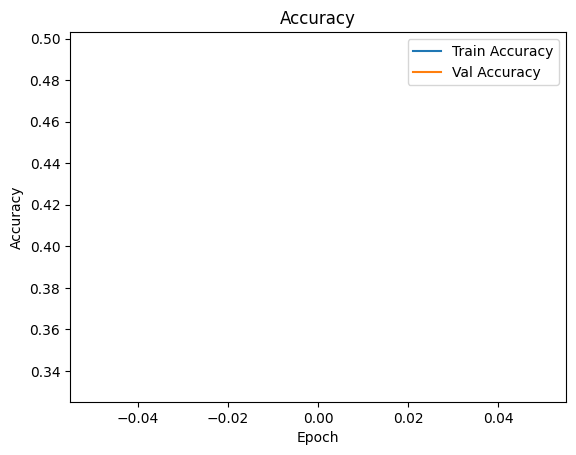

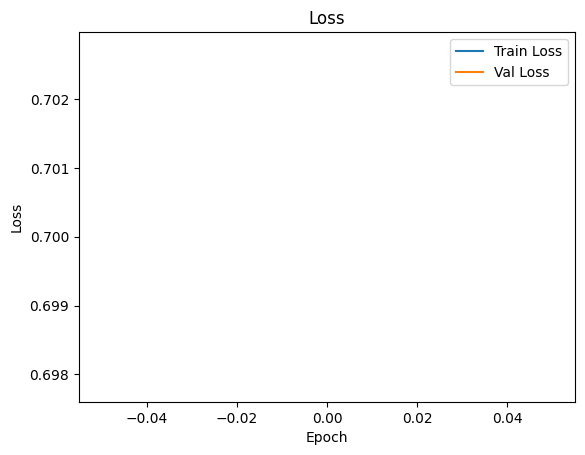

In [163]:
# Converting the training history to a dataframe

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [165]:
# # Evaluating the Model

# results = model.evaluate(val_ds)
# print(f"Validation Loss: {results[0]:.4f}")
# print(f"Validation Accuracy: {results[1]:.4f}")

In [ ]:
# Making predictions on a few examples

for images, labels in val_ds.take[1]:
  preds = model.predict(images)
  preds_binary = (preds >0.5).astype(int)
  print("Predictions: ", preds_binary.flatteen())
  print("True Labels: ", labels.numpy())